In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


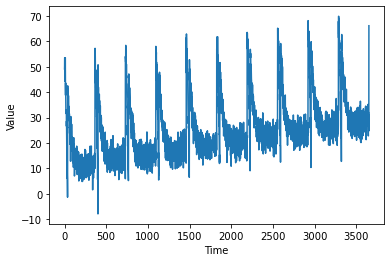

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size*5, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 7s 17ms/step - loss: 29.5181 - mae: 30.0181
Epoch 2/100
94/94 [==============================] - 2s 18ms/step - loss: 25.4435 - mae: 25.9432
Epoch 3/100
94/94 [==============================] - 2s 17ms/step - loss: 21.1054 - mae: 21.6041
Epoch 4/100
94/94 [==============================] - 2s 18ms/step - loss: 16.8821 - mae: 17.3816
Epoch 5/100
94/94 [==============================] - 2s 18ms/step - loss: 12.7601 - mae: 13.2594
Epoch 6/100
94/94 [==============================] - 2s 18ms/step - loss: 8.6171 - mae: 9.1064
Epoch 7/100
94/94 [==============================] - 2s 18ms/step - loss: 6.1633 - mae: 6.6374
Epoch 8/100
94/94 [==============================] - 2s 18ms/step - loss: 5.4903 - mae: 5.9617
Epoch 9/100
94/94 [==============================] - 2s 18ms/step - loss: 5.4982 - mae: 5.9710
Epoch 10/100
94/94 [==============================] - 2s 18ms/step - loss: 5.3795 - mae: 5.8533
Epoch 11/100
94/94 [===================

94/94 [==============================] - 2s 18ms/step - loss: 2.8082 - mae: 3.2757
Epoch 87/100
94/94 [==============================] - 2s 18ms/step - loss: 3.7614 - mae: 4.2378
Epoch 88/100
94/94 [==============================] - 2s 18ms/step - loss: 3.0061 - mae: 3.4739
Epoch 89/100
94/94 [==============================] - 2s 18ms/step - loss: 2.9507 - mae: 3.4187
Epoch 90/100
94/94 [==============================] - 2s 18ms/step - loss: 3.1613 - mae: 3.6301
Epoch 91/100
94/94 [==============================] - 2s 18ms/step - loss: 3.4363 - mae: 3.9078
Epoch 92/100
94/94 [==============================] - 2s 18ms/step - loss: 3.6365 - mae: 4.1126
Epoch 93/100
94/94 [==============================] - 2s 20ms/step - loss: 2.9476 - mae: 3.4149
Epoch 94/100
94/94 [==============================] - 2s 18ms/step - loss: 3.2169 - mae: 3.6848
Epoch 95/100
94/94 [==============================] - 2s 18ms/step - loss: 3.1189 - mae: 3.5892
Epoch 96/100
94/94 [==============================] -

(1e-08, 0.0001, 0.0, 30.0)

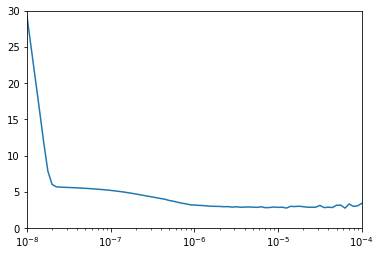

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size*5, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 7s 17ms/step - loss: 467.6181 - mae: 13.8827
Epoch 2/500
94/94 [==============================] - 2s 17ms/step - loss: 33.3588 - mae: 3.9284
Epoch 3/500
94/94 [==============================] - 2s 17ms/step - loss: 23.3706 - mae: 3.2929
Epoch 4/500
94/94 [==============================] - 2s 18ms/step - loss: 24.4874 - mae: 3.3829
Epoch 5/500
94/94 [==============================] - 2s 18ms/step - loss: 23.9492 - mae: 3.3746
Epoch 6/500
94/94 [==============================] - 2s 18ms/step - loss: 23.7840 - mae: 3.4026
Epoch 7/500
94/94 [==============================] - 2s 17ms/step - loss: 21.4395 - mae: 3.1844
Epoch 8/500
94/94 [==============================] - 2s 17ms/step - loss: 24.2102 - mae: 3.4209
Epoch 9/500
94/94 [==============================] - 2s 18ms/step - loss: 20.2201 - mae: 3.1863
Epoch 10/500
94/94 [==============================] - 2s 18ms/step - loss: 20.9743 - mae: 3.1715
Epoch 11/500
94/94 [=================

94/94 [==============================] - 2s 18ms/step - loss: 20.2690 - mae: 3.0236
Epoch 86/500
94/94 [==============================] - 2s 18ms/step - loss: 18.8356 - mae: 3.0508
Epoch 87/500
94/94 [==============================] - 2s 18ms/step - loss: 21.3832 - mae: 3.0753
Epoch 88/500
94/94 [==============================] - 2s 18ms/step - loss: 19.1482 - mae: 2.9609
Epoch 89/500
94/94 [==============================] - 2s 19ms/step - loss: 19.2286 - mae: 2.9784
Epoch 90/500
94/94 [==============================] - 2s 18ms/step - loss: 18.6061 - mae: 2.9389
Epoch 91/500
94/94 [==============================] - 2s 19ms/step - loss: 18.7768 - mae: 3.0344
Epoch 92/500
94/94 [==============================] - 2s 19ms/step - loss: 21.2240 - mae: 3.0486
Epoch 93/500
94/94 [==============================] - 2s 18ms/step - loss: 17.9866 - mae: 2.9251
Epoch 94/500
94/94 [==============================] - 2s 18ms/step - loss: 20.5621 - mae: 3.0383
Epoch 95/500
94/94 [=======================

94/94 [==============================] - 2s 17ms/step - loss: 17.9591 - mae: 2.8670
Epoch 169/500
94/94 [==============================] - 2s 17ms/step - loss: 18.0931 - mae: 2.9796
Epoch 170/500
94/94 [==============================] - 2s 17ms/step - loss: 18.9855 - mae: 2.9932
Epoch 171/500
94/94 [==============================] - 2s 17ms/step - loss: 17.9100 - mae: 2.9324
Epoch 172/500
94/94 [==============================] - 2s 17ms/step - loss: 18.1043 - mae: 2.9223
Epoch 173/500
94/94 [==============================] - 2s 17ms/step - loss: 21.8484 - mae: 3.1468
Epoch 174/500
94/94 [==============================] - 2s 17ms/step - loss: 17.3947 - mae: 2.8538
Epoch 175/500
94/94 [==============================] - 2s 17ms/step - loss: 19.5457 - mae: 3.0124
Epoch 176/500
94/94 [==============================] - 2s 17ms/step - loss: 19.4102 - mae: 3.0591
Epoch 177/500
94/94 [==============================] - 2s 17ms/step - loss: 19.4667 - mae: 2.9121
Epoch 178/500
94/94 [=============

94/94 [==============================] - 2s 17ms/step - loss: 18.2125 - mae: 3.0547
Epoch 252/500
94/94 [==============================] - 2s 18ms/step - loss: 21.4541 - mae: 3.0398
Epoch 253/500
94/94 [==============================] - 2s 18ms/step - loss: 17.6743 - mae: 2.8634
Epoch 254/500
94/94 [==============================] - 2s 18ms/step - loss: 18.4007 - mae: 2.9985
Epoch 255/500
94/94 [==============================] - 2s 17ms/step - loss: 18.8143 - mae: 2.8714
Epoch 256/500
94/94 [==============================] - 2s 17ms/step - loss: 19.6883 - mae: 2.9966
Epoch 257/500
94/94 [==============================] - 2s 17ms/step - loss: 17.5181 - mae: 2.9117
Epoch 258/500
94/94 [==============================] - 2s 17ms/step - loss: 19.9273 - mae: 2.9351
Epoch 259/500
94/94 [==============================] - 2s 17ms/step - loss: 18.9958 - mae: 3.0049
Epoch 260/500
94/94 [==============================] - 2s 17ms/step - loss: 20.4566 - mae: 3.0021
Epoch 261/500
94/94 [=============

94/94 [==============================] - 2s 18ms/step - loss: 18.0829 - mae: 2.9131
Epoch 335/500
94/94 [==============================] - 2s 18ms/step - loss: 17.0799 - mae: 2.9090
Epoch 336/500
94/94 [==============================] - 2s 18ms/step - loss: 20.5681 - mae: 2.9471
Epoch 337/500
94/94 [==============================] - 2s 18ms/step - loss: 20.9673 - mae: 2.9335
Epoch 338/500
94/94 [==============================] - 2s 18ms/step - loss: 20.5893 - mae: 2.9258
Epoch 339/500
94/94 [==============================] - 2s 18ms/step - loss: 17.9839 - mae: 2.8190
Epoch 340/500
94/94 [==============================] - 2s 18ms/step - loss: 22.4457 - mae: 3.0197
Epoch 341/500
94/94 [==============================] - 2s 18ms/step - loss: 19.4129 - mae: 2.8727
Epoch 342/500
94/94 [==============================] - 2s 18ms/step - loss: 19.0699 - mae: 2.9439
Epoch 343/500
94/94 [==============================] - 2s 18ms/step - loss: 18.4024 - mae: 2.8654
Epoch 344/500
94/94 [=============

94/94 [==============================] - 2s 18ms/step - loss: 20.5054 - mae: 2.9631
Epoch 418/500
94/94 [==============================] - 2s 18ms/step - loss: 15.5370 - mae: 2.7591
Epoch 419/500
94/94 [==============================] - 2s 18ms/step - loss: 18.3434 - mae: 2.9116
Epoch 420/500
94/94 [==============================] - 2s 18ms/step - loss: 17.9488 - mae: 2.8820
Epoch 421/500
94/94 [==============================] - 2s 18ms/step - loss: 16.2393 - mae: 2.8413
Epoch 422/500
94/94 [==============================] - 2s 18ms/step - loss: 17.6392 - mae: 2.8301
Epoch 423/500
94/94 [==============================] - 2s 18ms/step - loss: 17.3168 - mae: 2.9125
Epoch 424/500
94/94 [==============================] - 2s 18ms/step - loss: 15.8277 - mae: 2.8013
Epoch 425/500
94/94 [==============================] - 2s 18ms/step - loss: 20.3813 - mae: 3.0008
Epoch 426/500
94/94 [==============================] - 2s 18ms/step - loss: 16.2903 - mae: 2.7753
Epoch 427/500
94/94 [=============

94/94 [==============================] - 2s 18ms/step - loss: 20.4520 - mae: 2.9867


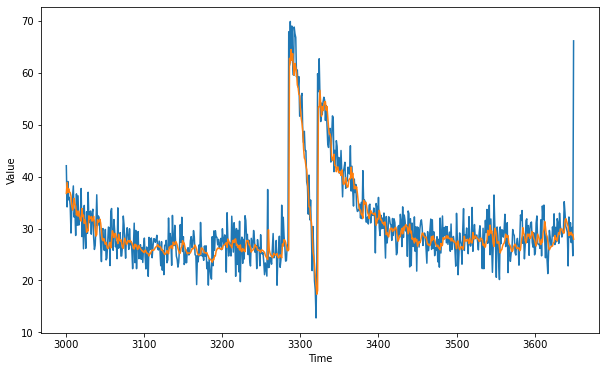

In [10]:
forecast = []
results = []

forecast = [model.predict(series[time:time + window_size][np.newaxis]) for time in range(len(series) - window_size)]

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

2.8508134

<Figure size 432x288 with 0 Axes>

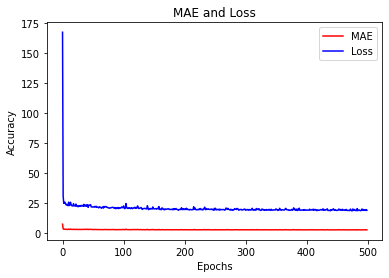

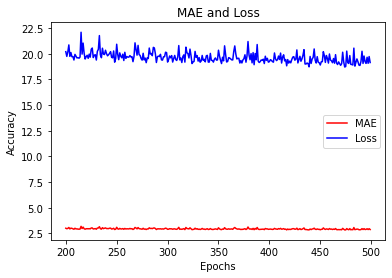

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()